In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
import joblib

# plt.rcParams['font.family']='Times New Roman,Microsoft YaHei'# 设置字体族，中文为微软雅黑，英文为Times New Roman
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['mathtext.fontset'] = 'stix'  # 设置数学公式字体为stix
plt.rcParams["text.usetex"] = False
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

C:\Users\aa271\AppData\Local\Temp\ipykernel_14096\1941341006.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [2]:
datajh = pd.read_csv("groupedjh.csv")
datacm = pd.read_csv("groupedcm.csv")

In [3]:
datacm

,Time,甲硫醇浓度,"1,3-丁二烯浓度",丁烯浓度,丙酮、丁烷浓度,正丙醇浓度,甲硫醚、乙硫醇浓度,氯乙烷浓度,异戊二烯浓度,戊烯浓度,...,地面层湿度,TVOCs,Hour_Min_Sec,Hour_Min,Hour,Month,Day,Season,Datetime,seconds
0,2022-08-06 15:54:41,2.0,4.0,0.0,1.000,1.2,2.0,0.80,0.00,0.0,...,95.80000,44.016667,15:54:41,15:54,15,Aug,6,Summer,2022-08-06 15:54:41,57281
1,2022-08-06 15:54:48,3.0,2.0,0.0,1.000,0.8,2.0,1.00,6.00,2.0,...,95.80000,66.200000,15:54:48,15:54,15,Aug,6,Summer,2022-08-06 15:54:48,57288
2,2022-08-06 15:54:55,2.0,4.0,0.0,1.000,0.9,1.0,1.00,8.00,0.5,...,95.80000,73.200000,15:54:55,15:54,15,Aug,6,Summer,2022-08-06 15:54:55,57295
3,2022-08-06 15:55:02,2.0,4.0,0.0,1.000,2.1,1.0,1.00,5.00,0.0,...,95.80000,63.600000,15:55:02,15:55,15,Aug,6,Summer,2022-08-06 15:55:02,57302
4,2022-08-06 15:55:09,2.0,3.0,0.0,1.000,1.5,1.0,0.90,5.00,2.0,...,95.80000,59.400000,15:55:09,15:55,15,Aug,6,Summer,2022-08-06 15:55:09,57309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151532,2023-07-25 11:39:05,0.0,0.0,0.0,1.630,0.0,0.0,0.00,0.00,0.0,...,67.66375,6.000000,11:39:05,11:39,11,Jul,25,Summer,2023-07-25 11:39:05,41945
151533,2023-07-25 11:39:12,0.0,0.0,0.0,1.490,0.0,0.0,0.00,0.00,0.0,...,67.79750,5.670000,11:39:12,11:39,11,Jul,25,Summer,2023-07-25 11:39:12,41952
151534,2023-07-25 11:39:19,0.0,0.0,0.0,2.335,0.0,0.0,0.00,0.00,0.0,...,67.93125,7.345000,11:39:19,11:39,11,Jul,25,Summer,2023-07-25 11:39:19,41959
151535,2023-07-25 11:39:26,0.0,0.0,0.0,1.340,0.0,0.0,0.00,0.00,0.0,...,68.06500,7.110000,11:39:26,11:39,11,Jul,25,Summer,2023-07-25 11:39:26,41966


In [43]:
# 将'Datetime'转换为日期时间格式，并设置为索引
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.sort_values('Datetime', inplace=True)
data.set_index('Datetime', inplace=True)

# 选择一个典型的空气质量指标列作为PM2.5的代理，这里我们使用'TVOCs'列
# 计算每6秒和每小时的平均值
data_7s = data['PM2.5'].resample('7S').mean().dropna()
data_1h = data['PM2.5'].resample('1H').mean().dropna()

# 去除极端值：使用四分位距IQR来识别和移除极端值
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))]

data_7s_clean = remove_outliers(data_7s)
data_1h_clean = remove_outliers(data_1h)

# 将6秒平均数据映射到小时的小数点上
data_7s_hourly = data_7s_clean.copy()
data_7s_hourly.index = data_7s_hourly.index.hour + data_7s_hourly.index.minute / 60 + data_7s_hourly.index.second / 3600

# 对于箱线图，需要一个小时的小数表示来对应每个点
data_1h_hourly = data_1h_clean.copy()
data_1h_hourly.index = data_1h_hourly.index.hour + data_1h_hourly.index.minute / 60

# 准备绘图数据：折线图数据的小时小数表示
line_data_hourly = data_7s_hourly.groupby(data_7s_hourly.index).mean()



C:\Users\aa271\AppData\Local\Temp\ipykernel_14096\433385900.py:33: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax1.legend([line], ['6s Avg'], loc='upper left', fontsize=12)
C:\Users\aa271\AppData\Local\Temp\ipykernel_14096\433385900.py:34: UserWarning: Legend does not support handles for AxesSubplot instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax2.legend([box], ['1h Avg'], loc='upper right', fontsize=12)


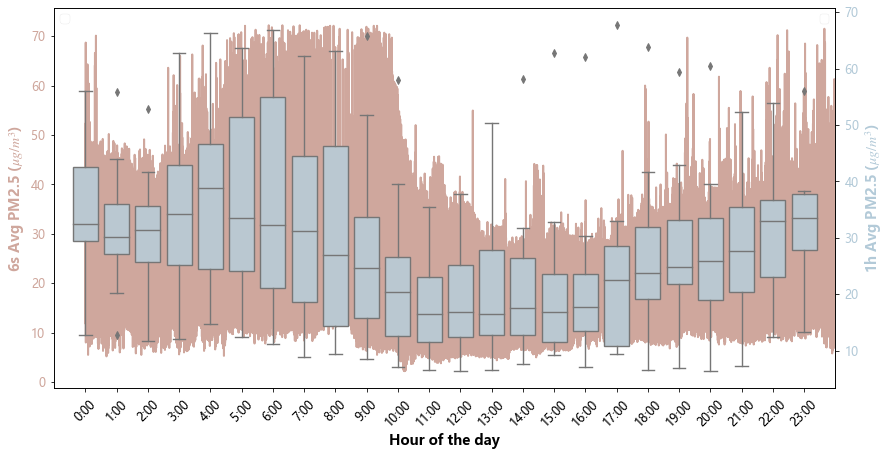

In [46]:
from matplotlib.ticker import FixedLocator, FuncFormatter
fig, ax1 = plt.subplots(figsize=(14, 7))

color = '#CFA79D'
ax1.set_xlabel('Hour of the day', fontsize=14, fontweight='bold')
ax1.set_ylabel('6s Avg PM2.5 ($μg/m^3$)', color=color, fontsize=14, fontweight='bold')
line = ax1.plot(line_data_hourly.index, line_data_hourly, color=color, label='7s Avg', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color, labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
ax1.set_xlim([-1, 24])  # 设置x轴范围为0到24小时


# 实例化一个新的y轴
ax2 = ax1.twinx()
color = '#B3CAD8'
ax2.set_ylabel('1h Avg PM2.5 ($μg/m^3$)', color=color, fontsize=14, fontweight='bold')
box = sns.boxplot(x=data_1h_hourly.index, y=data_1h_hourly.values, ax=ax2, color=color, saturation=0.6)
ax2.tick_params(axis='y', labelcolor=color, labelsize=12)

# 修改箱线图的外观
for i,artist in enumerate(ax2.artists):
    # 设置箱体的颜色和透明度
    artist.set_edgecolor('black')
    artist.set_facecolor('skyblue')
    # 每个箱体的线条粗细
    for j in range(i*6,i*6+6):
        line = ax2.lines[j]
        line.set_color('black')
        line.set_mfc('black')
        line.set_mec('black')

# 添加图例
ax1.legend([line], ['6s Avg'], loc='upper left', fontsize=12)
ax2.legend([box], ['1h Avg'], loc='upper right', fontsize=12)

# 在绘图代码中设置x轴的刻度和刻度标签
ax1.set_xticks(range(0, 24))  # 设置x轴的刻度位置
ax1.set_xticklabels([f'{i}:00' for i in range(0,24)], rotation=45)  # 设置x轴的刻度标签，并旋转45度以改善显示

# 确保这些更改也应用到第二个y轴上，以保持x轴刻度一致
ax2.set_xticks(range(0, 24))  # 这一步可能不是必须的，因为ax2共享ax1的x轴


# plt.title('夏季崇明PM2.5浓度日变异', fontsize=16, fontweight='bold')
plt.xlim(-1, 24)  # 确保x轴范围正确

# plt.tight_layout()
plt.savefig("PM2.5变异崇明.svg")
plt.savefig("PM2.5变异崇明.jpg",dpi=600)
plt.show()
